In [1]:
import os, sys
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [2]:
sys.path.append('../..')

In [19]:
from lib.datasets import get_train_test_img_ids_split, get_kfolds
from lib.consts import patches_csv_path, patches_path

In [4]:
df = pd.read_csv(patches_csv_path)

In [5]:
df.shape

(2576729, 12)

In [6]:
gr_by_id_df = df.groupby('image_id').count()['data_provider']

In [7]:
gr_by_id_df

image_id
0005f7aaab2800f6170c399693a96917    167
000920ad0b612851f8e01bcc880d9b3d     78
0018ae58b01bdadc8e347995b69f99aa    370
001c62abd11fa4b57bf7a6c603a11bb9    203
001d865e65ef5d2579c190a0e0350d8f    378
                                   ... 
ffd2841373b39792ab0c84cccd066e31    750
ffdc59cd580a1468eac0e6a32dd1ff2d    168
ffe06afd66a93258f8fabdef6044e181    297
ffe236a25d4cbed59438220799920749    270
ffe9bcababc858e04840669e788065a1    269
Name: data_provider, Length: 10515, dtype: int64

In [8]:
gr_by_id_df.min(), gr_by_id_df.max(), gr_by_id_df.mean()

(8, 1101, 245.052686638136)

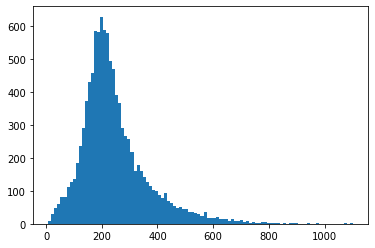

In [9]:
plt.hist(gr_by_id_df.values, bins=100);

In [10]:
(gr_by_id_df < 100).sum()

585

In [11]:
train_img_ids, test_img_ids = get_train_test_img_ids_split()

In [12]:
train_img_ids[:3], test_img_ids[:3]

(['eaf66ac783499827a7f09d69793a07d7',
  'ea035a96c752f59a4934a91068b318f2',
  '4c0d7290c72b5495df6c337b1e5dee88'],
 ['e8baa3bb9dcfb9cef5ca599d62bb8046',
  '9b2948ff81b64677a1a152a1532c1a50',
  '5b003d43ec0ce5979062442486f84cf7'])

In [13]:
len(train_img_ids), len(test_img_ids)

(8492, 2124)

In [14]:
for k, (k_train_idxs, k_test_idxs) in enumerate(get_kfolds(train_img_ids)):
    print(k_train_idxs, k_test_idxs)

[   1    2    3 ... 8487 8489 8491] [   0    8   14 ... 8485 8488 8490]
[   0    1    2 ... 8488 8489 8490] [  12   15   29 ... 8482 8483 8491]
[   0    1    2 ... 8489 8490 8491] [   6    7   11 ... 8484 8486 8487]
[   0    6    7 ... 8488 8490 8491] [   1    2    3 ... 8478 8479 8489]


In [23]:
import torch
import cv2

In [47]:
def imread(fname, channels_first=False):
    img = cv2.imread(fname)
    try:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    except Exception as e:
        if os.path.isfile(fname):
            raise e
        else:
            raise Exception('file not found {}'.format(fname))
    if channels_first:
        img = img.transpose([2, 0, 1])
        
    return img

In [139]:
max_lbl_nums = 6
actual_lbl_nums = 6 + 3
provider_nums = 2
isup_grade_nums = 6

gleason_scores = {
    '0+0': 0, 
    'negative': 0,
    '3+3': 1, 
    '3+4': 2,
    '4+3': 3,
    '4+4': 4,
    '5+3': 5,
    '3+5': 6,
    '4+5': 7,
    '5+4': 8,
    '5+5': 9       
}

gleason_score_nums = len(gleason_scores) - 1

In [140]:
def get_actual_lbl_num(data_provider, lbl):
    return lbl if data_provider == 'radboud' else lbl + max_lbl_nums

def get_provider_num(data_provider):
    return 0 if data_provider == 'radboud' else 1

def get_g_score_num(score):
    return gleason_scores[score]

In [511]:
class PatchesDataset(torch.utils.data.Dataset):
    def __init__(self, image_ids, csv_path=patches_csv_path, 
                 path=patches_path, scale=1, transform=None,
                 load_masks=True):
        df = pd.read_csv(csv_path)
        self.df = df[df['image_id'].isin(image_ids)]
        self.path = patches_path
        self.scale = scale
        self.transform = transform
        self.load_masks = load_masks

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image_id, y, x = row.image_id, row.y, row.x
        
        img = imread(os.path.join(self.path, f"imgs/{image_id}_{y}_{x}.jpeg"))

        if self.load_masks:
            r_mask = imread(os.path.join(self.path, f"masks/{image_id}_{y}_{x}.png"))[..., 0]
            mask = np.zeros(r_mask.shape, dtype=np.int64)
            for i in range(max_lbl_nums):
                mask[r_mask == i] = get_actual_lbl_num(row.data_provider, i)
        else:
            mask = None
            
        if self.scale != 1:
            img = cv2.resize(img, None, fx=self.scale, fy=self.scale)
            if mask is not None:
                mask = cv2.resize(mask, None, fx=self.scale, fy=self.scale)
        
        if self.transform:
            img, mask = self.transform(img, mask)
        
        labes = np.zeros(actual_lbl_nums, dtype=np.float32)
        for i in range(max_lbl_nums if row.data_provider == 'radboud' else 3):
            labes[get_actual_lbl_num(row.data_provider, i)] = row[f'label{i}']

        return (img.transpose([2, 0, 1]).astype(np.float32), 
                mask.astype(np.int64), 
                labes.astype(np.float32), 
                get_provider_num(row.data_provider),
                int(row.isup_grade), get_g_score_num(row.gleason_score))

In [512]:
import albumentations as alb

In [472]:
# HorizontalFlip, VerticalFlip, Transpose, RandomRotate90

In [513]:
p = 0.8
aug = alb.Compose([
    alb.RandomRotate90(),
    alb.Flip(),
    alb.Transpose(),
    alb.ShiftScaleRotate(shift_limit=0.0625, 
                         scale_limit=0.2, 
                         rotate_limit=0, 
                         p=0.5),
    alb.CLAHE(clip_limit=2),
    alb.RandomContrast(p=0.2),
    alb.RandomBrightness(p=0.2),
    alb.RandomGamma(p=0.2),
    alb.HueSaturationValue(p=0.2),
    alb.RGBShift(p=0.2),
    alb.OneOf([
        alb.IAAAdditiveGaussianNoise(),
        alb.GaussNoise(),
    ], p=0.5),
    alb.OneOf([
        alb.MotionBlur(p=0.2),
        alb.MedianBlur(blur_limit=11, p=0.2),
        alb.Blur(blur_limit=11, p=0.2),
    ], p=0.5),
], p=p)

def augment(img, mask):
    augmented = aug(image=img, mask=mask)
    
    img = augmented['image']
    mask = augmented['mask']
    
    img = img / 255
    
    return img, mask

In [480]:
a_img, a_mask = augment(img, mask)

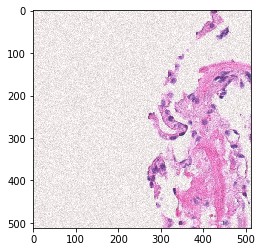

In [484]:
plt.imshow(a_img*255);

In [477]:
train_dataset = PatchesDataset(train_img_ids, transform=augment)

In [478]:
img, mask, labes, provider, isup_grade, g_score = next(iter(train_dataset))

(512, 512, 3) (512, 512)


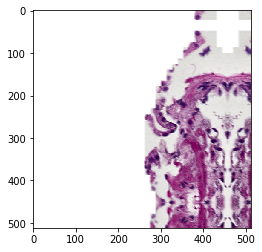

In [441]:
plt.imshow(img);

In [444]:
np.unique(mask[...])

array([6, 7], dtype=int32)

In [514]:
train_loader = torch.utils.data.DataLoader(
    PatchesDataset(train_img_ids, transform=augment),
    batch_size=64, shuffle=True, num_workers=0
)

In [515]:
img, mask, labes, provider, isup_grade, g_score = next(iter(train_loader))

In [516]:
img.shape

torch.Size([64, 3, 512, 512])

In [498]:
mask.dtype

torch.int64

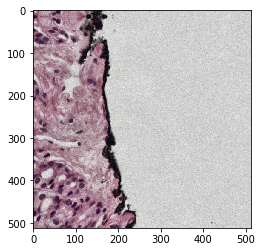

In [510]:
plt.imshow(img[8]);

In [70]:
row

image_id         000920ad0b612851f8e01bcc880d9b3d
data_provider                          karolinska
isup_grade                                      0
gleason_score                                 0+0
y                                               5
x                                              26
label0                                   0.628906
label1                                   0.371094
label2                                          0
label3                                          0
label4                                          0
label5                                          0
Name: 0, dtype: object